In [1]:
# package imports
import pandas as pd
import numpy as np 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] #正常显示中文
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.rc('figure', figsize=(10, 10))

from sklearn import metrics

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split

# EDA（Exploratory Data Analysis）

In [2]:
titanic = pd.read_csv('train.csv')
titanic.drop(columns = ['PassengerId','Name','Ticket','Embarked','Parch','SibSp'], inplace = True)

In [3]:
titanic.shape
titanic.info()

(891, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   Fare      891 non-null    float64
 5   Cabin     204 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 41.9+ KB


In [4]:
# num_features = ['Age', 'SibSp','Parch','Fare', 'Cabin']
num_features = ['Age', 'Fare']
cate_features = ['Pclass', 'Sex', 'Cabin']


for feature in cate_features:
    feature
    titanic[feature].value_counts()

'Pclass'

3    491
1    216
2    184
Name: Pclass, dtype: int64

'Sex'

male      577
female    314
Name: Sex, dtype: int64

'Cabin'

B96 B98        4
C23 C25 C27    4
G6             4
E101           3
C22 C26        3
              ..
E49            1
D50            1
D48            1
B86            1
B4             1
Name: Cabin, Length: 147, dtype: int64

## 相关系数

In [5]:
corr_matrix = titanic.corr()
corr_matrix['Survived'].sort_values()

Pclass     -0.338481
Age        -0.077221
Fare        0.257307
Survived    1.000000
Name: Survived, dtype: float64

# 特征工程

## 去掉某些feature

## 用模型填补缺失值（Age）

In [6]:
from sklearn.ensemble import RandomForestRegressor
def set_missing_ages(df):

    # 把已有的数值型特征取出来丢进Random Forest Regressor中
    age_df = df[['Age','Fare', 'Pclass']]

    # 乘客分成已知年龄和未知年龄两部分
    known_age = age_df[age_df['Age'].notna()]
    unknown_age = age_df[age_df['Age'].isna()]

    # y即目标年龄
    y = known_age.iloc[:, 0]

    # X即特征属性值
    X = known_age.iloc[:, 1:]

    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor()
    rfr.fit(X, y)

    # 用得到的模型进行未知年龄结果预测
    predictedAges = rfr.predict(unknown_age.iloc[:, 1:])
#     print predictedAges
    # 用得到的预测结果填补原缺失数据
    df.loc[df['Age'].isna(), 'Age' ] = predictedAges 

    return df, rfr

## Age<10 =is_cild

In [7]:
def set_child_type(df):
    df['is_child'] = 0
    df.loc[df['is_child']<14, 'is_child'] = 1
    return df

## 用有无缺失值去重新定义（Cabin）

In [8]:
def set_Cabin_type(df):
    df.loc[df['Cabin'].notna(), 'Cabin'] = 1
    df.loc[df['Cabin'].isna(), 'Cabin'] = 0
    return df

## 处理numeric、categorical数据

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

num_pipeline = make_pipeline(
    FunctionTransformer(set_child_type),  
    SimpleImputer(strategy="median"), #缺失值用中位数代替
    StandardScaler()#标准化
)
cate_pipeline = make_pipeline(
#     SimpleImputer(strategy='most_frequent'), #离散型数据用unknown补全
    FunctionTransformer(set_Cabin_type),
    OneHotEncoder(sparse=False)
)

# tmep = cate_pipeline.fit_transform(titanic[cate_features])
# temp.shape

In [10]:
from sklearn.compose import make_column_transformer

data_pipeline = make_column_transformer(
    (num_pipeline, num_features),
    (cate_pipeline, cate_features),
    remainder='passthrough'
    )
# train_prepared = full_pipeline.fit_transform()
# type(train_prepared)
# train_prepared.shape

# train_prepared = pd.DataFrame(train_prepared, columns=X_train.columns)
# train_prepared.info()

## 特征选择。比如：查看特征工程后的相关系数。待定

In [11]:
# corr_matrix = titanic.corr()
# corr_matrix['Survived'].sort_values()

# 模型选择

## 划分数据集

In [12]:
X_titanic = titanic.drop('Survived', axis = 1)
label = titanic['Survived']


# 将数据集按照`3:7`的比例，切分为训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X_titanic, label, test_size = 0.3, random_state = 42)
type(X_test)

pandas.core.frame.DataFrame

Todo

In [13]:
# 用模型填补Age缺失值（思考怎么加入Pipline）
# X_train, rfr = set_missing_ages(X_train)
# tmp_df = X_test[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
# null_age = tmp_df[X_test['Age'].isna()]
# X = null_age.iloc[:, 1:]
# predictedAges = rfr.predict(X)
# X_test.loc[X_test['Age'].isna(), 'Age'] = predictedAges

# X_train.loc[X_train['Embarked'].isna(), 'Embarked'] = 's'
# X_test.loc[X_test['Embarked'].isna(), 'Embarked'] = 's'

#加入pipeline出错，先手动处理
# X_train = set_child_type(X_train)
# X_train = set_Cabin_type(X_train)

# X_test = set_child_type(X_test)
# X_test = set_Cabin_type(X_test)

test

## 组合pipeline（模型+数据处理）

## 模型训练

In [121]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

### LogisticRegression

In [17]:
model = LogisticRegression(C=0.5)
model

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [122]:
model = GradientBoostingClassifier()

### RandomForestClassifier

In [19]:
model = RandomForestClassifier(max_leaf_nodes=350)

### VotingClassifier

In [42]:
# model = RandomForestClassifier(random_state=42)
# model = LogisticRegression(random_state=42)
# model = GradientBoostingClassifier(random_state=42)
model = VotingClassifier(
    estimators=[
        ('log_clf', LogisticRegression()),
        ('ab_clf', AdaBoostClassifier()),
#         ('svm_clf', SVC(probability=True)),
        ('rf_clf', RandomForestClassifier()),
        ('gbdt_clf', GradientBoostingClassifier())
    ], voting='soft')

# gg.get_params('votingclassifier')
# for m in model.estimators_:
#     m
#     X_test = data_pipeline.transform(X_test)
#     m.score(X_test, Y_test)


### Stacking

In [89]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import StackingClassifier

# models = [
#     AdaBoostClassifier(),
#     SVC(probability=True),
#     LogisticRegression(C=0.1,max_iter=100),
#     RandomForestClassifier(n_estimators=100,max_depth=6,oob_score=True),
#     GradientBoostingClassifier(learning_rate=0.3,max_depth=6,n_estimators=100)
# ]


models=[
    ('ab_clf', AdaBoostClassifier()),
    ('log_clf', LogisticRegression()),
    ('svm_clf', SVC(probability=True)),
    ('rf_clf', RandomForestClassifier()),
    ('gbdt_clf', GradientBoostingClassifier())
]


model = StackingClassifier(estimators=models, final_estimator=LogisticRegression())


### catboost

In [15]:
from catboost import CatBoostClassifier

model = CatBoostClassifier()

### xgboost

In [21]:
import xgboost as xgb
model = xgb.XGBClassifier()

### lightgbm

In [26]:
import lightgbm as lgbm

model = lgbm.LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=50,
                                learning_rate=0.1, bagging_fraction=0.9, feature_fraction=0.9, reg_lambda=0.2)

## 模型验证

### 交叉验证

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
gg =  Pipeline([('data_pipeline', data_pipeline), ('model', model)])

# lin_scores = cross_val_score(gg, X_train, Y_train, cv=10)
# lin_scores
# lin_scores.mean()

# gg.score(X_test, Y_test)
# Y_pred = gg.predict(X_test)
# print("Accuracy : %.4g" % metrics.accuracy_score(Y_test, Y_pred))

### learning curve

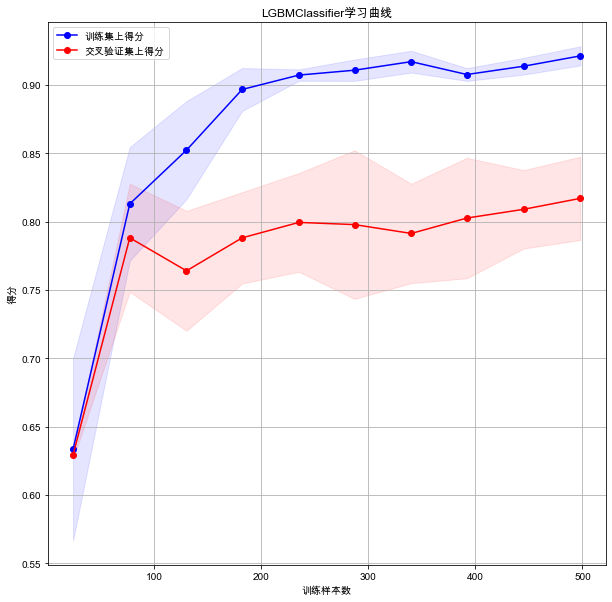

(0.8574081895826235, 0.14175839655697142)

In [28]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, 
                        train_sizes=np.linspace(0.1, 1.0, 8), verbose=0, plot=True):
    """
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 你用的分类器。
    title : 表格的标题。
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为5份)
    n_jobs : 并行的的任务数(默认1)
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, verbose=verbose)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(u"训练样本数")
        plt.ylabel(u"得分")
        plt.gca().invert_yaxis()
        plt.grid()
    
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                         alpha=0.1, color="b")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                         alpha=0.1, color="r")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label=u"训练集上得分")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="r", label=u"交叉验证集上得分")
    
        plt.legend(loc="best")
        
        plt.draw()
        plt.gca().invert_yaxis()
        plt.show()
    
    midpoint = ((train_scores_mean[-1] + train_scores_std[-1]) + (test_scores_mean[-1] - test_scores_std[-1])) / 2
    diff = (train_scores_mean[-1] + train_scores_std[-1]) - (test_scores_mean[-1] - test_scores_std[-1])
    return midpoint, diff

plot_learning_curve(gg, gg['model'].__class__.__name__+'学习曲线', X_train, Y_train)

# 保存结果

In [29]:
gg.fit(X_train, Y_train) 
test_data = pd.read_csv('test.csv')
output = pd.DataFrame({'PassengerId': test_data.PassengerId})
test_data.drop(columns = ['PassengerId','Name','Ticket','Embarked','Parch','SibSp'], inplace = True)

predictions = gg.predict(test_data)
output['Survived'] = predictions
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Pipeline(memory=None,
         steps=[('data_pipeline',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('functiontransformer',
                                                                   FunctionTransformer(accept_sparse=False,
                                                                                       check_inverse=True,
                                                                                       func=<function set_child_type at 0x1a1a85b560>,
                                                                                       inv_kw_args=None,
                                                                        

Your submission was successfully saved!


In [ ]:
# model.coef

In [ ]:
# data_pipeline.get_feature_names()